## FTP Connection

### Connection Parameters

In [1]:
server = "opendata.dwd.de"
user   = "anonymous"
passwd = ""

### FTP Directory Definition and Station Description Filename Pattern

In [2]:
# The topic of interest.
topic_dir = "/daily/kl/historical/"
#topic_dir = "/daily/soil_temperature/historical/"

# This is the search pattern common to ALL station description file names 
station_desc_pattern = "_Beschreibung_Stationen.txt"

# Below this directory tree node all climate data are stored.
ftp_climate_data_dir = "/climate_environment/CDC/observations_germany/climate/"
ftp_dir =  ftp_climate_data_dir + topic_dir

### Local Directories

In [3]:
local_ftp_dir         = "F:/Masters/Semester2/GeoInfo/asessment/MIE_2.02_GeoInfo_WS2019/gi0000_Final_Assignment/data/temperature/original/DWD/"      # Local directory to store local ftp data copies, the local data source or input data. 
local_ftp_station_dir = local_ftp_dir + topic_dir # Local directory where local station info is located
local_ftp_ts_dir      = local_ftp_dir + topic_dir # Local directory where time series downloaded from ftp are located

local_generated_dir   = "F:/Masters/Semester2/GeoInfo/asessment/MIE_2.02_GeoInfo_WS2019/gi0000_Final_Assignment/data/temperature/generated/DWD/" # The generated of derived data in contrast to local_ftp_dir
local_station_dir     = local_generated_dir + topic_dir # Derived station data, i.e. the CSV file
local_ts_merged_dir   = local_generated_dir + topic_dir # Parallel merged time series, wide data frame with one TS per column
local_ts_appended_dir = local_generated_dir + topic_dir # Serially appended time series, long data frame for QGIS TimeManager Plugin

In [4]:
print(local_ftp_dir)
print(local_ftp_station_dir)
print(local_ftp_ts_dir)
print()
print(local_generated_dir)
print(local_station_dir)
print(local_ts_merged_dir)
print(local_ts_appended_dir)

F:/Masters/Semester2/GeoInfo/asessment/MIE_2.02_GeoInfo_WS2019/gi0000_Final_Assignment/data/temperature/original/DWD/
F:/Masters/Semester2/GeoInfo/asessment/MIE_2.02_GeoInfo_WS2019/gi0000_Final_Assignment/data/temperature/original/DWD//daily/kl/historical/
F:/Masters/Semester2/GeoInfo/asessment/MIE_2.02_GeoInfo_WS2019/gi0000_Final_Assignment/data/temperature/original/DWD//daily/kl/historical/

F:/Masters/Semester2/GeoInfo/asessment/MIE_2.02_GeoInfo_WS2019/gi0000_Final_Assignment/data/temperature/generated/DWD/
F:/Masters/Semester2/GeoInfo/asessment/MIE_2.02_GeoInfo_WS2019/gi0000_Final_Assignment/data/temperature/generated/DWD//daily/kl/historical/
F:/Masters/Semester2/GeoInfo/asessment/MIE_2.02_GeoInfo_WS2019/gi0000_Final_Assignment/data/temperature/generated/DWD//daily/kl/historical/
F:/Masters/Semester2/GeoInfo/asessment/MIE_2.02_GeoInfo_WS2019/gi0000_Final_Assignment/data/temperature/generated/DWD//daily/kl/historical/


In [5]:
import os
os.makedirs(local_ftp_dir,exist_ok = True) # it does not complain if the dir already exists.
os.makedirs(local_ftp_station_dir,exist_ok = True)
os.makedirs(local_ftp_ts_dir,exist_ok = True)

os.makedirs(local_generated_dir,exist_ok = True)
os.makedirs(local_station_dir,exist_ok = True)
os.makedirs(local_ts_merged_dir,exist_ok = True)
os.makedirs(local_ts_appended_dir,exist_ok = True)

### FTP Connect

In [6]:
import ftplib
ftp = ftplib.FTP(server)
res = ftp.login(user=user, passwd = passwd)
print(res)

230 Login successful.


In [7]:
ret = ftp.cwd(".")

In [8]:
#ftp.quit()

### FTP Grab File Function

In [9]:
def grabFile(ftpfullname,localfullname):
    try:
        ret = ftp.cwd(".") # A dummy action to chack the connection and to provoke an exception if necessary.
        localfile = open(localfullname, 'wb')
        ftp.retrbinary('RETR ' + ftpfullname, localfile.write, 1024)
        localfile.close()
    
    except ftplib.error_perm:
        print("FTP ERROR. Operation not permitted. File not found?")

    except ftplib.error_temp:
        print("FTP ERROR. Timeout.")

    except ConnectionAbortedError:
        print("FTP ERROR. Connection aborted.")



### Generate Pandas Dataframe from FTP Directory Listing

In [10]:
import pandas as pd
import os

def gen_df_from_ftp_dir_listing(ftp, ftpdir):
    lines = []
    flist = []
    try:    
        res = ftp.retrlines("LIST "+ftpdir, lines.append)
    except:
        print("Error: ftp.retrlines() failed. ftp timeout? Reconnect!")
        return
        
    if len(lines) == 0:
        print("Error: ftp dir is empty")
        return
    
    for line in lines:
#        print(line)
        [ftype, fsize, fname] = [line[0:1], int(line[31:42]), line[56:]]
#        itemlist = [line[0:1], int(line[31:42]), line[56:]]
#        flist.append(itemlist)
        
        fext = os.path.splitext(fname)[-1]
        
        if fext == ".zip":
            station_id = int(fname.split("_")[2])
        else:
            station_id = -1 
        
        flist.append([station_id, fname, fext, fsize, ftype])
        
        

    df_ftpdir = pd.DataFrame(flist,columns=["station_id", "name", "ext", "size", "type"])
    return(df_ftpdir)

In [11]:
df_ftpdir = gen_df_from_ftp_dir_listing(ftp, ftp_dir)

In [12]:
df_ftpdir.head(10)

,station_id,name,ext,size,type
0,-1,BESCHREIBUNG_obsgermany_climate_daily_kl_histo...,.pdf,74902,-
1,-1,DESCRIPTION_obsgermany_climate_daily_kl_histor...,.pdf,73419,-
2,-1,KL_Tageswerte_Beschreibung_Stationen.txt,.txt,267457,-
3,1,tageswerte_KL_00001_19370101_19860630_hist.zip,.zip,282024,-
4,3,tageswerte_KL_00003_18910101_20110331_hist.zip,.zip,887544,-
5,11,tageswerte_KL_00011_19800901_20181231_hist.zip,.zip,83682,-
6,44,tageswerte_KL_00044_19690101_20181231_hist.zip,.zip,416393,-
7,52,tageswerte_KL_00052_19690101_20011231_hist.zip,.zip,261747,-
8,61,tageswerte_KL_00061_19750701_19780831_hist.zip,.zip,32904,-
9,70,tageswerte_KL_00070_19730601_19860930_hist.zip,.zip,100354,-


### Dataframe with TS Zip Files

In [13]:
#df_ftpdir["ext"]==".zip"
df_zips = df_ftpdir[df_ftpdir["ext"]==".zip"]
df_zips.set_index("station_id", inplace = True)
df_zips.head(10)

,name,ext,size,type
station_id,,,,
1,tageswerte_KL_00001_19370101_19860630_hist.zip,.zip,282024,-
3,tageswerte_KL_00003_18910101_20110331_hist.zip,.zip,887544,-
11,tageswerte_KL_00011_19800901_20181231_hist.zip,.zip,83682,-
44,tageswerte_KL_00044_19690101_20181231_hist.zip,.zip,416393,-
52,tageswerte_KL_00052_19690101_20011231_hist.zip,.zip,261747,-
61,tageswerte_KL_00061_19750701_19780831_hist.zip,.zip,32904,-
70,tageswerte_KL_00070_19730601_19860930_hist.zip,.zip,100354,-
71,tageswerte_KL_00071_19861101_20181231_hist.zip,.zip,200328,-
72,tageswerte_KL_00072_19780901_19950531_hist.zip,.zip,155186,-


### Download the Station Description File

In [14]:
station_fname = df_ftpdir[df_ftpdir['name'].str.contains(station_desc_pattern)]["name"].values[0]
print(station_fname)

# ALternative
#station_fname2 = df_ftpdir[df_ftpdir["name"].str.match("^.*Beschreibung_Stationen.*txt$")]["name"].values[0]
#print(station_fname2)

KL_Tageswerte_Beschreibung_Stationen.txt


In [15]:
print("grabFile: ")
print("From: " + ftp_dir + station_fname)
print("To:   " + local_ftp_station_dir + station_fname)
grabFile(ftp_dir + station_fname, local_ftp_station_dir + station_fname)

grabFile: 
From: /climate_environment/CDC/observations_germany/climate//daily/kl/historical/KL_Tageswerte_Beschreibung_Stationen.txt
To:   F:/Masters/Semester2/GeoInfo/asessment/MIE_2.02_GeoInfo_WS2019/gi0000_Final_Assignment/data/temperature/original/DWD//daily/kl/historical/KL_Tageswerte_Beschreibung_Stationen.txt


In [16]:
# extract column names. They are in German (de)
# We have to use codecs because of difficulties with character encoding (German Umlaute)
import codecs

def station_desc_txt_to_csv(txtfile, csvfile):
    file = codecs.open(txtfile,"r","utf-8")
    r = file.readline()
    file.close()
    colnames_de = r.split()
    colnames_de
    
    translate = \
    {'Stations_id':'station_id',
     'von_datum':'date_from',
     'bis_datum':'date_to',
     'Stationshoehe':'altitude',
     'geoBreite': 'latitude',
     'geoLaenge': 'longitude',
     'Stationsname':'name',
     'Bundesland':'state'}
    
    colnames_en = [translate[h] for h in colnames_de]
    
    # Skip the first two rows and set the column names.
    df = pd.read_fwf(txtfile,skiprows=2,names=colnames_en, parse_dates=["date_from","date_to"],index_col = 0)
    
    # write csv
    df.to_csv(csvfile, sep = ";")
    return(df)

In [17]:
basename = os.path.splitext(station_fname)[0]
df_stations = station_desc_txt_to_csv(local_ftp_station_dir + station_fname, local_station_dir + basename + ".csv")
df_stations.head()

,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
1,1937-01-01,1986-06-30,478,47.8413,8.8493,Aach,Baden-Württemberg
3,1891-01-01,2011-03-31,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
11,1980-09-01,2020-02-28,680,47.9737,8.5205,Donaueschingen (Landeplatz),Baden-Württemberg
44,1969-01-01,2020-02-28,44,52.9336,8.2370,Großenkneten,Niedersachsen
52,1969-01-01,2001-12-31,46,53.6623,10.1990,Ahrensburg-Wulfsdorf,Schleswig-Holstein


### Select Stations Located in/ near Xanten from Station Description Dataframe

In [18]:
station_ids_selected = df_stations[df_stations['state'].str.contains("Nordrhein")].index
station_ids_selected

Int64Index([    3,    98,   186,   326,   386,   390,   553,   554,   555,
              598,
            ...
            13696, 13700, 13713, 13901, 13952, 15000, 15120, 15190, 15200,
            15963],
           dtype='int64', name='station_id', length=112)

In [19]:
# Create variable with TRUE if area is Xanten or near Xanten
isNRW = df_stations['state'] == "Nordrhein-Westfalen"

# Create variable with TRUE if date_to is latest date (indicates operation up to now)
# isOperational = df_stations['date_to'] == df_stations.date_to.max() 
isOperational = df_stations['date_to'] == df_stations.date_to.max() 

isBefore1950 = df_stations['date_from'] > '1940'

#Availabe data between 2016 to 2018
on_sensing_date = (df_stations['date_from']<='2016') & (df_stations['date_to']>='2018')

#Station near xanten
xanten_lat = df_stations[df_stations['name'].str.contains('Xanten')]['latitude'].iloc[0]
xanten_long = df_stations[df_stations['name'].str.contains('Xanten')]['longitude'].iloc[0]
nearXanten = (df_stations['latitude'] < xanten_lat + 0.39) & (df_stations['latitude'] > xanten_lat - 0.39) & (df_stations['longitude'] < xanten_long + 0.4) & (df_stations['longitude'] > xanten_long - 0.4)

# select on both conditions
dfNRW = df_stations[isNRW & nearXanten & on_sensing_date]
#print("Number of stations in/near Xanten: \n", dfNRW.count())
dfNRW

,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
1078,1952-01-01,2020-02-28,37,51.2960,6.7686,Düsseldorf,Nordrhein-Westfalen
1590,1963-10-01,2020-02-28,37,51.4942,6.2463,Geldern-Walbeck,Nordrhein-Westfalen
2629,1947-11-11,2020-02-28,46,51.7612,6.0954,Kleve,Nordrhein-Westfalen
13670,2007-05-31,2020-02-28,24,51.5088,6.7018,Duisburg-Baerl,Nordrhein-Westfalen


In [20]:
print(df_zips.head())

                                                      name   ext    size type
station_id                                                                   
1           tageswerte_KL_00001_19370101_19860630_hist.zip  .zip  282024    -
3           tageswerte_KL_00003_18910101_20110331_hist.zip  .zip  887544    -
11          tageswerte_KL_00011_19800901_20181231_hist.zip  .zip   83682    -
44          tageswerte_KL_00044_19690101_20181231_hist.zip  .zip  416393    -
52          tageswerte_KL_00052_19690101_20011231_hist.zip  .zip  261747    -


### Download TS Data from FTP Server

Problem: Not all stations listed in the station description file are associated with a time series (zip file)! The stations in the description file and the set of stations whoch are TS data provided for (zip files) do not match perfectly.  

In [21]:
list(dfNRW.index)

[1078, 1590, 2629, 13670]

In [22]:
# Add the names of the zip files only to a list. 
local_zip_list = []

station_ids_selected = list(dfNRW.index)

for station_id in station_ids_selected:
    try:
        fname = df_zips["name"][station_id]
        print(fname)
        grabFile(ftp_dir + fname, local_ftp_ts_dir + fname)
        local_zip_list.append(fname)
    except:
        print("WARNING: TS file for key %d not found in FTP directory." % station_id)

tageswerte_KL_01078_19520101_20181231_hist.zip
tageswerte_KL_01590_19631001_20181231_hist.zip
tageswerte_KL_02629_19471111_20181231_hist.zip
tageswerte_KL_13670_20070531_20181231_hist.zip


### Join (Merge) the Time Series Columns

https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd


In [23]:
def temp_ts_to_df(fname):
    
    dateparse = lambda dates: [pd.datetime.strptime(str(d), '%Y%m%d') for d in dates]

    df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse, na_values = [-999.0, -999])

    #df = pd.read_csv(fname, delimiter=";", encoding="iso8859_2",\
    #             index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse)
    
    # https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd

    # Column headers: remove leading blanks (strip), replace " " with "_", and convert to lower case.
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
    df.index.name = df.index.name.strip().lower().replace(' ', '_').replace('(', '').replace(')', '')
    
    #Filter Date
    df = df[((df.index >= "2016-05-01") & (df.index <= "2016-06-30")) | ((df.index >= "2017-05-01") & (df.index <= "2017-06-30") | (df.index >= "2018-05-01") & (df.index <= "2018-06-30"))]
    return(df)

In [24]:
from zipfile import ZipFile

In [25]:
def temp_ts_merge():
    # Very compact code.
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0] 
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
                dftmp = temp_ts_to_df(myfile)
                s = dftmp["tmk"].rename(dftmp["stations_id"][0]).to_frame()
                # outer merge.
                df = pd.merge(df, s, left_index=True, right_index=True, how='outer')

    #df.index.names = ["year"]
    df.index.rename(name = "time", inplace = True)
    return(df)

In [26]:
df_merged_ts = temp_ts_merge()

Zip archive: F:/Masters/Semester2/GeoInfo/asessment/MIE_2.02_GeoInfo_WS2019/gi0000_Final_Assignment/data/temperature/original/DWD//daily/kl/historical/tageswerte_KL_01078_19520101_20181231_hist.zip
Extract product file: produkt_klima_tag_19520101_20181231_01078.txt

Zip archive: F:/Masters/Semester2/GeoInfo/asessment/MIE_2.02_GeoInfo_WS2019/gi0000_Final_Assignment/data/temperature/original/DWD//daily/kl/historical/tageswerte_KL_01590_19631001_20181231_hist.zip
Extract product file: produkt_klima_tag_19631001_20181231_01590.txt

Zip archive: F:/Masters/Semester2/GeoInfo/asessment/MIE_2.02_GeoInfo_WS2019/gi0000_Final_Assignment/data/temperature/original/DWD//daily/kl/historical/tageswerte_KL_02629_19471111_20181231_hist.zip
Extract product file: produkt_klima_tag_19471111_20181231_02629.txt

Zip archive: F:/Masters/Semester2/GeoInfo/asessment/MIE_2.02_GeoInfo_WS2019/gi0000_Final_Assignment/data/temperature/original/DWD//daily/kl/historical/tageswerte_KL_13670_20070531_20181231_hist.zip
E

In [27]:
df_merged_ts.head()

,1078,1590,2629,13670
time,,,,
2016-05-01,9.1,8.7,8.3,9.4
2016-05-02,11.9,12.4,12.5,12.4
2016-05-03,11.2,11.3,10.9,11.3
2016-05-04,9.5,10.1,9.9,10.2
2016-05-05,12.9,13.9,13.7,14.3


## Filtering only May and June date from dataset

In [28]:
if df_merged_ts.index.dtype != "int64":
    df_merged_ts.reset_index(level=0, inplace=True)

In [33]:
date_from = pd.Timestamp(2016, 5, 1)
date_to = pd.Timestamp(2016, 6, 30)

df_selectedRange_2016 = pd.DataFrame()

ifBetweenDate  = (df_merged_ts['time'] <= date_to) & (df_merged_ts['time'] >= date_from)
dataFrame = df_merged_ts[ifBetweenDate]
dataFrame = pd.concat([dataFrame['time'], dataFrame[1078], dataFrame[1590], dataFrame[2629], dataFrame[13670]], axis=1)
df_selectedRange_2016 = df_selectedRange_2016.append(dataFrame)

date_from = pd.Timestamp(2017, 5, 1)
date_to = pd.Timestamp(2017, 6, 30)

df_selectedRange_2017 = pd.DataFrame()

ifBetweenDate  = (df_merged_ts['time'] <= date_to) & (df_merged_ts['time'] >= date_from)
dataFrame = df_merged_ts[ifBetweenDate]
dataFrame = pd.concat([dataFrame['time'], dataFrame[1078], dataFrame[1590], dataFrame[2629], dataFrame[13670]], axis=1)
df_selectedRange_2017 = df_selectedRange_2017.append(dataFrame)

date_from = pd.Timestamp(2018, 5, 1)
date_to = pd.Timestamp(2018, 6, 30)

df_selectedRange_2018 = pd.DataFrame()

ifBetweenDate  = (df_merged_ts['time'] <= date_to) & (df_merged_ts['time'] >= date_from)
dataFrame = df_merged_ts[ifBetweenDate]
dataFrame = pd.concat([dataFrame['time'], dataFrame[1078], dataFrame[1590], dataFrame[2629], dataFrame[13670]], axis=1)
df_selectedRange_2018 = df_selectedRange_2018.append(dataFrame)

# df_selectedRange_2016

In [53]:
print("Average Temperature of Düsseldorf(1078):")
print("For 2016(My to June): ", df_selectedRange_2016[1078].mean())
print("For 2017(My to June): ", df_selectedRange_2017[1078].mean())
print("For 2018(My to June): ", df_selectedRange_2018[1078].mean())
print()

print("Average Temperature of Geldern-Walbeck(1590):")
print("For 2016(My to June): ", df_selectedRange_2016[1590].mean())
print("For 2017(My to June): ", df_selectedRange_2017[1590].mean())
print("For 2018(My to June): ", df_selectedRange_2018[1590].mean())
print()

print("Average Temperature of Kleve(2629):")
print("For 2016(My to June): ", df_selectedRange_2016[2629].mean())
print("For 2017(My to June): ", df_selectedRange_2017[2629].mean())
print("For 2018(My to June): ", df_selectedRange_2018[2629].mean())
print()

print("Average Temperature of Duisburg-Baerl(13670):")
print("For 2016(My to June): ", df_selectedRange_2016[13670].mean())
print("For 2017(My to June): ", df_selectedRange_2017[13670].mean())
print("For 2018(My to June): ", df_selectedRange_2018[13670].mean())
print()

Average Temperature of Düsseldorf(1078):
For 2016(My to June):  16.29344262295082
For 2017(My to June):  17.750819672131147
For 2018(My to June):  17.826229508196718

Average Temperature of Geldern-Walbeck(1590):
For 2016(My to June):  16.37868852459016
For 2017(My to June):  17.304918032786883
For 2018(My to June):  17.814754098360655

Average Temperature of Kleve(2629):
For 2016(My to June):  15.967213114754099
For 2017(My to June):  16.886885245901645
For 2018(My to June):  17.485245901639342

Average Temperature of Duisburg-Baerl(13670):
For 2016(My to June):  16.58688524590164
For 2017(My to June):  17.785245901639342
For 2018(My to June):  18.28360655737705



## Ploting the data

In [34]:
%matplotlib inline

In [35]:
import matplotlib.pyplot as plt
import numpy as np

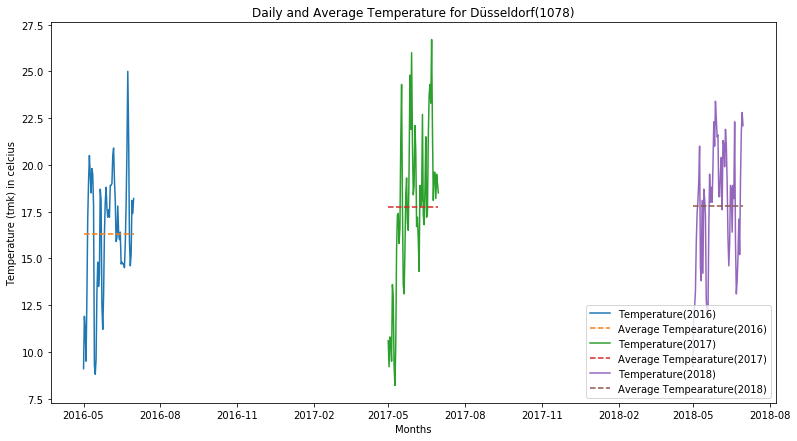

In [59]:
x_2016 = np.array(df_selectedRange_2016['time'])
y_2016 = np.array(df_selectedRange_2016[1078])

x_2017 = np.array(df_selectedRange_2017['time'])
y_2017 = np.array(df_selectedRange_2017[1078])

x_2018 = np.array(df_selectedRange_2018['time'])
y_2018 = np.array(df_selectedRange_2018[1078])

mean_temp_2016 = [np.mean(df_selectedRange_2016[1078])] * len(x_2016)

mean_temp_2017 = [np.mean(df_selectedRange_2017[1078])] * len(x_2017)

mean_temp_2018 = [np.mean(df_selectedRange_2018[1078])] * len(x_2018)

fig,ax = plt.subplots(figsize=(13, 7))

# Plot the data
ax.set_title('Daily and Average Temperature for Düsseldorf(1078)')
ax.set_xlabel('Months')
ax.set_ylabel('Temperature (tmk) in celcius')

data_line_2016 = ax.plot(x_2016,y_2016, label='Temperature(2016)')
# Plot the average line
mean_line_2016 = ax.plot(x_2016,mean_temp_2016, label='Average Tempearature(2016)', linestyle='--')

data_line_2017 = ax.plot(x_2017,y_2017, label='Temperature(2017)')
# Plot the average line
mean_line_2017 = ax.plot(x_2017,mean_temp_2017, label='Average Tempearature(2017)', linestyle='--')

data_line_2018 = ax.plot(x_2018,y_2018, label='Temperature(2018)')
# Plot the average line
mean_line_2018 = ax.plot(x_2018,mean_temp_2018, label='Average Tempearature(2018)', linestyle='--')

# Make a legend
legend = ax.legend(loc='lower right')

plt.show()


In [38]:
df_merged_ts.to_csv(local_ts_merged_dir + "ts_merged.csv",sep=";")

## Finalized data by appending

In [39]:
def ts_append():
    # Very compact code.
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0] 
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
                dftmp = temp_ts_to_df(myfile)
                dftmp = dftmp.merge(df_stations,how="inner",left_on="stations_id",right_on="station_id",right_index=True)
#                print(dftmp.head(5))
                df = df.append(dftmp)

    #df.index.names = ["year"]
    #df.index.rename(name = "time", inplace = True)
    return(df)

In [40]:
df_appended_ts = ts_append()

Zip archive: F:/Masters/Semester2/GeoInfo/asessment/MIE_2.02_GeoInfo_WS2019/gi0000_Final_Assignment/data/temperature/original/DWD//daily/kl/historical/tageswerte_KL_01078_19520101_20181231_hist.zip
Extract product file: produkt_klima_tag_19520101_20181231_01078.txt

Zip archive: F:/Masters/Semester2/GeoInfo/asessment/MIE_2.02_GeoInfo_WS2019/gi0000_Final_Assignment/data/temperature/original/DWD//daily/kl/historical/tageswerte_KL_01590_19631001_20181231_hist.zip
Extract product file: produkt_klima_tag_19631001_20181231_01590.txt

Zip archive: F:/Masters/Semester2/GeoInfo/asessment/MIE_2.02_GeoInfo_WS2019/gi0000_Final_Assignment/data/temperature/original/DWD//daily/kl/historical/tageswerte_KL_02629_19471111_20181231_hist.zip
Extract product file: produkt_klima_tag_19471111_20181231_02629.txt

Zip archive: F:/Masters/Semester2/GeoInfo/asessment/MIE_2.02_GeoInfo_WS2019/gi0000_Final_Assignment/data/temperature/original/DWD//daily/kl/historical/tageswerte_KL_13670_20070531_20181231_hist.zip
E

In [41]:
df_appended_ts.head()

,stations_id,qn_3,fx,fm,qn_4,rsk,rskf,sdk,shk_tag,nm,...,tnk,tgk,eor,date_from,date_to,altitude,latitude,longitude,name,state
mess_datum,,,,,,,,,,,,,,,,,,,,,
2016-05-01,1078,10.0,11.1,4.5,3.0,0.0,6.0,8.633,0.0,4.0,...,3.7,0.7,eor,1952-01-01,2020-02-28,37,51.296,6.7686,Düsseldorf,Nordrhein-Westfalen
2016-05-02,1078,10.0,6.2,1.8,3.0,2.4,6.0,11.000,0.0,3.6,...,1.7,-0.2,eor,1952-01-01,2020-02-28,37,51.296,6.7686,Düsseldorf,Nordrhein-Westfalen
2016-05-03,1078,10.0,12.7,4.6,3.0,0.0,0.0,7.000,0.0,3.4,...,3.4,-0.4,eor,1952-01-01,2020-02-28,37,51.296,6.7686,Düsseldorf,Nordrhein-Westfalen
2016-05-04,1078,10.0,7.2,2.1,3.0,0.0,0.0,13.233,0.0,1.3,...,0.8,-2.0,eor,1952-01-01,2020-02-28,37,51.296,6.7686,Düsseldorf,Nordrhein-Westfalen
2016-05-05,1078,10.0,11.8,3.7,3.0,0.0,0.0,14.200,0.0,2.6,...,2.5,-1.0,eor,1952-01-01,2020-02-28,37,51.296,6.7686,Düsseldorf,Nordrhein-Westfalen


In [42]:
df_xanten = df_appended_ts[df_appended_ts["name"].str.contains('Xanten')]

In [43]:
df_appended_ts.to_csv(local_ts_appended_dir + "ts_appended.csv",sep=";")